In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform, GlorotUniform
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [21]:
def load_idx3_ubyte(file_path):
    with open(file_path, 'rb') as f:
        data = f.read()
    num_images = int.from_bytes(data[4:8], byteorder='big')
    rows = int.from_bytes(data[8:12], byteorder='big')
    cols = int.from_bytes(data[12:16], byteorder='big')
    images = np.frombuffer(data[16:], dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_idx1_ubyte(file_path):
    with open(file_path, 'rb') as f:
        data = f.read()
    num_labels = int.from_bytes(data[4:8], byteorder='big')
    labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels

# Load data
train_images = load_idx3_ubyte("train-images.idx3-ubyte")
train_labels = load_idx1_ubyte("train-labels.idx1-ubyte")
test_images = load_idx3_ubyte("t10k-images.idx3-ubyte")
test_labels = load_idx1_ubyte("t10k-labels.idx1-ubyte")

print(f"Train Images Shape: {train_images.shape}")  
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")  
print(f"Test Labels Shape: {test_labels.shape}")


Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


In [22]:
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
test_images = test_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

In [23]:
print(f"Train Shape After Reshape: {train_images.shape}")
print(f"Test Shape After Reshape: {test_images.shape}")

Train Shape After Reshape: (60000, 28, 28, 1)
Test Shape After Reshape: (10000, 28, 28, 1)


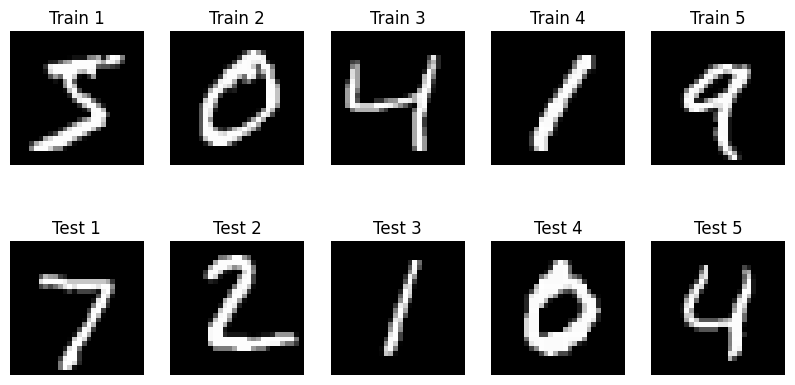

In [24]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):
    axes[0, i].imshow(train_images[i].reshape(28,28), cmap='gray')
    axes[0, i].set_title(f"Train {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(test_images[i].reshape(28,28), cmap='gray')
    axes[1, i].set_title(f"Test {i+1}")
    axes[1, i].axis('off')

plt.show()

In [25]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

train_generator = datagen.flow(
    train_images, train_labels,
    batch_size=64,
    subset='training'
)

val_generator = datagen.flow(
    train_images, train_labels,
    batch_size=64,
    subset='validation'
)

In [26]:
from tensorflow.keras import layers, models, regularizers, callbacks
model = models.Sequential([
    # Feature Extraction
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Classification Head
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
from tensorflow.keras import layers, models

# Define a CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")  # Output layer (10 classes)
])

# Show model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)

In [33]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[lr_schedule, early_stop]
)


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7719 - loss: 0.7163 - val_accuracy: 0.9532 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9572 - loss: 0.1440 - val_accuracy: 0.9670 - val_loss: 0.1084 - learning_rate: 0.0010
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9708 - loss: 0.0955 - val_accuracy: 0.9752 - val_loss: 0.0790 - learning_rate: 0.0010
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9767 - loss: 0.0742 - val_accuracy: 0.9737 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9807 - loss: 0.0630 - val_accuracy: 0.9841 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9839 - loss: 0.0544 - val_accuracy: 0.9814 - val_loss: 0.0596 - learning_rate: 0.0010
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9846 - l

In [36]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

313/313 - 1s - 2ms/step - accuracy: 0.9949 - loss: 0.0171
Test Loss: 0.017069566994905472
Test Accuracy: 0.9948999881744385


In [37]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9935 - loss: 0.0197
Test Accuracy: 99.49%


In [43]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, y_pred_classes, target_names=[str(i) for i in range(10)]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


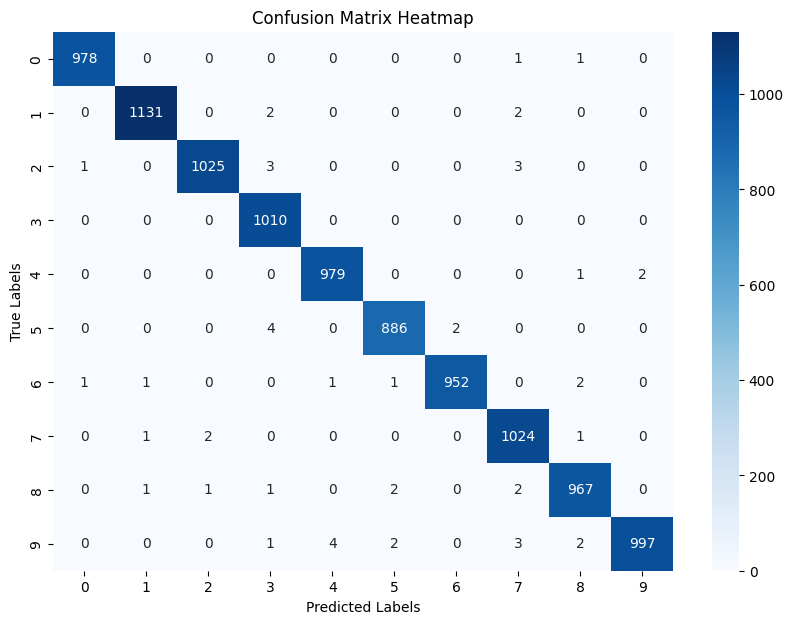

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the model
y_pred = model.predict(test_images)  # Assuming `model` and `test_images` are defined
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


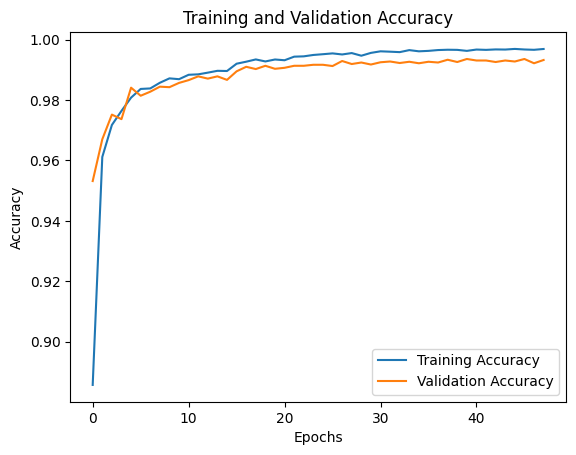

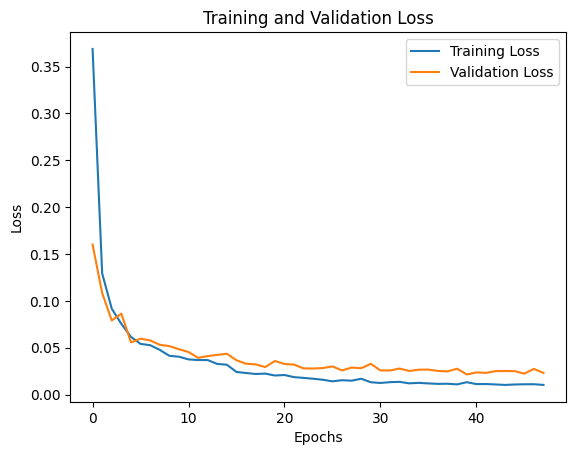

In [39]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_accuracy = [accuracy_score(y_test[y_test == i], y_pred[y_test == i]) for i in range(10)]
plt.bar(np.arange(10), class_accuracy)
plt.xlabel('Digit Class')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Digit Class')
plt.show()


In [41]:
model.save("model2.h5")